In [1]:
import tensorflow
import tensorflow as tf
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from keras.models import Model
from keras.utils import plot_model
import os
import tensorflow.keras.layers as layers

2024-02-08 15:36:37.306977: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-02-08 15:36:37.879060: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-08 15:36:37.879158: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-08 15:36:37.980764: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-08 15:36:38.179620: I tensorflow/core/platform/cpu_feature_guar

In [2]:
input_dir = "images/"
target_dir = "annotations/trimaps"
img_size = (160, 160)
num_classes = 3
batch_size = 32

In [3]:
input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)
target_img_paths = sorted(
    [
        os.path.join(target_dir, fname)
        for fname in os.listdir(target_dir)
        if fname.endswith(".png") and not fname.startswith(".")
    ]
)

print("Number of samples:", len(input_img_paths))

for input_path, target_path in zip(input_img_paths[:10], target_img_paths[:10]):
    print(input_path, "|", target_path)

Number of samples: 7390
images/Abyssinian_1.jpg | annotations/trimaps/Abyssinian_1.png
images/Abyssinian_10.jpg | annotations/trimaps/Abyssinian_10.png
images/Abyssinian_100.jpg | annotations/trimaps/Abyssinian_100.png
images/Abyssinian_101.jpg | annotations/trimaps/Abyssinian_101.png
images/Abyssinian_102.jpg | annotations/trimaps/Abyssinian_102.png
images/Abyssinian_103.jpg | annotations/trimaps/Abyssinian_103.png
images/Abyssinian_104.jpg | annotations/trimaps/Abyssinian_104.png
images/Abyssinian_105.jpg | annotations/trimaps/Abyssinian_105.png
images/Abyssinian_106.jpg | annotations/trimaps/Abyssinian_106.png
images/Abyssinian_107.jpg | annotations/trimaps/Abyssinian_107.png


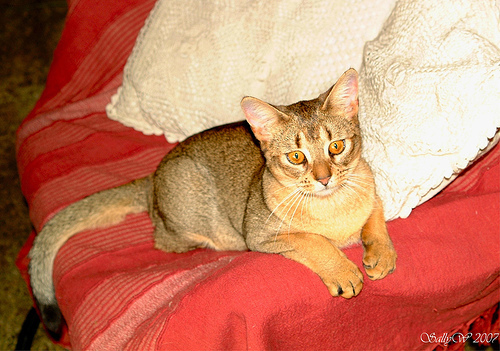

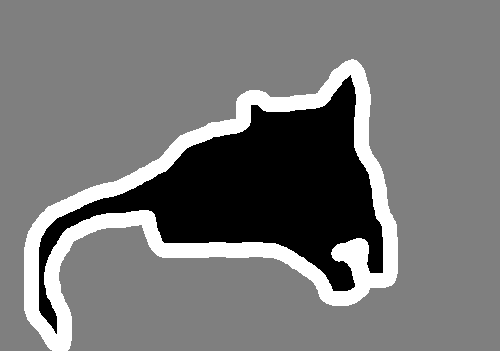

In [4]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
#import keras_preprocessing.image.
import PIL
from PIL import ImageOps

# Display input image #2
display(Image(filename=input_img_paths[5]))

# Display auto-contrast version of corresponding target (per-pixel categories)
img = PIL.ImageOps.autocontrast(load_img(target_img_paths[5]))
display(img)

In [5]:
from tensorflow.keras import utils
import numpy as np
from tensorflow.keras.preprocessing.image import load_img


class OxfordPetsDataGenerator(utils.Sequence):
    """Helper to iterate over the data (as Numpy arrays)."""

    def __init__(self, batch_size, img_size, input_img_paths, target_img_paths):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_paths = input_img_paths
        self.target_img_paths = target_img_paths

    def __len__(self):
        return len(self.target_img_paths) // self.batch_size

    def __getitem__(self, idx):
        """Returns tuple (input, target) correspond to batch #idx."""
        i = idx * self.batch_size
        batch_input_img_paths = self.input_img_paths[i : i + self.batch_size]
        batch_target_img_paths = self.target_img_paths[i : i + self.batch_size]

        # Filling in the feature image data
        x = np.zeros((self.batch_size,) + self.img_size + (3,), dtype="float32")
        for j, path in enumerate(batch_input_img_paths):

            # loads in the image and resizes in the target size
            img = load_img(path, target_size=self.img_size)
            x[j] = img

        # Filling in the label data
        y = np.zeros((self.batch_size,) + self.img_size + (1,), dtype="uint8")
        for j, path in enumerate(batch_target_img_paths):
            img = load_img(path, target_size=self.img_size, color_mode="grayscale")
            y[j] = np.expand_dims(img, 2)
            # Ground truth labels are 1, 2, 3. Subtract one to make them 0, 1, 2:
            y[j] -= 1

        return x, y

In [6]:
import random

# Split our img paths into a training and a validation set
val_samples = 1000
random.Random(42).shuffle(input_img_paths)
random.Random(42).shuffle(target_img_paths)

# Splitting data accoring to val_samples
train_input_img_paths = input_img_paths[:-val_samples]
train_target_img_paths = target_img_paths[:-val_samples]

val_input_img_paths = input_img_paths[-val_samples:]
val_target_img_paths = target_img_paths[-val_samples:]

# Instantiating data generators for training and validation sets
train_gen = OxfordPetsDataGenerator(batch_size, img_size, train_input_img_paths, train_target_img_paths)
val_gen = OxfordPetsDataGenerator(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_gen = OxfordPetsDataGenerator(batch_size, img_size, val_input_img_paths, val_target_img_paths)

In [7]:
image_size = 160

In [8]:
def down_block(x, filters, kernel_size=(3, 4), padding="same", strides=1):
    c = layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    #c = tf.nn.dropout(c, 0.5) #add one dropout
    p = layers.MaxPool2D((2,2), (2, 2))(c)
    return c, p

def up_block(x, skip, filters, kernel_size=(3, 4), padding="same", strides=1):
    up_sample = layers.UpSampling2D((2, 2))(x)
    concat = layers.Concatenate()([up_sample, skip])
    c = layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(concat)
    c = layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

def bottleneck(x, filters, kernel_size=(3, 4), padding="same", strides=1):
    c = layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(x)
    c = layers.Conv2D(filters, kernel_size, padding=padding, strides=strides, activation="relu")(c)
    return c

In [9]:
def unet():
    f = [16, 32, 64, 128, 256]

    inputs = layers.Input((image_size, image_size, 3))
    p0 = inputs
    c1, p1 = down_block(p0, 64) #128 -> 64
    c2, p2 = down_block(p1, 64*2) #64 -> 32
    c3, p3 = down_block(p2, 64*4) #32 -> 16
    c4, p4 = down_block(p3, 64*8) #16 ->8

    bn = bottleneck(p4, 64*16)

    u1 = up_block(bn, c4, 64*8) #8 ->16
    u2 = up_block(u1, c3, 64*4) #16 ->32
    u3 = up_block(u2, c2, 64*2) #32 ->64
    u4 = up_block(u3, c1, 64) #64 -> 128

    outputs = layers.Conv2D(3, 1, padding="same", activation="sigmoid")(u4)
    model = tf.keras.models.Model(inputs, outputs)
    return model

In [10]:
optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4)

2024-02-08 15:36:49.125859: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-08 15:36:49.425985: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-02-08 15:36:49.426137: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [11]:
from tensorflow.keras.metrics import IoU
model = unet()
model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy")

In [12]:
model_hist = model.fit(train_gen, epochs=15, validation_data=val_gen)

Epoch 1/15


2024-02-08 15:36:52.983391: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-02-08 15:36:53.256558: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-02-08 15:36:56.695701: I external/local_xla/xla/service/service.cc:168] XLA service 0x7efdbf8c9620 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-02-08 15:36:56.695720: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4090 Laptop GPU, Compute Capability 8.9
2024-02-08 15:36:56.733973: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-02-08 15:36:56.884980: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
I0000 00:00:1707377816.944886   16799 devic

 12/199 [>.............................] - ETA: 1:57 - loss: 1.9805

KeyboardInterrupt: 

31/31 [==============================] - 7s 217ms/step


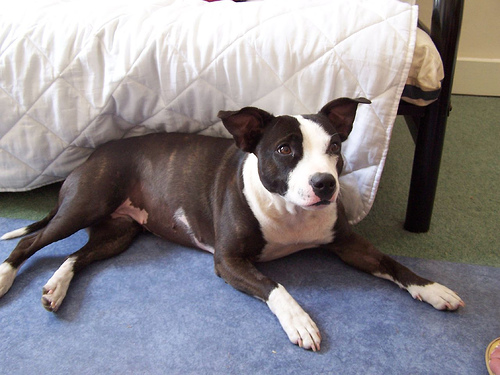

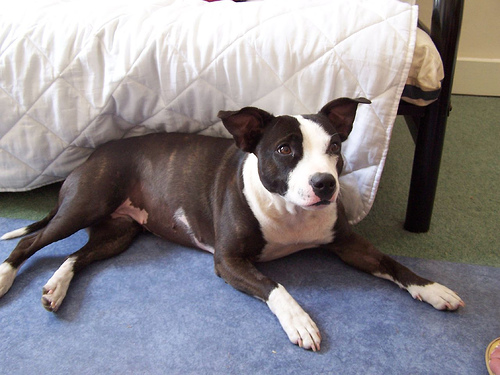

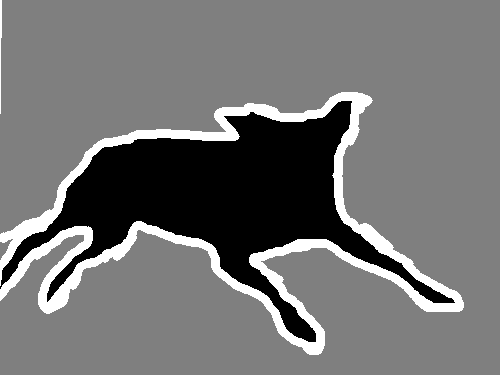

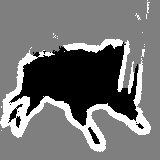

In [17]:
val_gen = OxfordPetsDataGenerator(batch_size, img_size, val_input_img_paths, val_target_img_paths)
val_preds = model.predict(val_gen)


def display_mask(i):
    """Quick utility to display a model's prediction."""
    mask = np.argmax(val_preds[i], axis=-1)
    mask = np.expand_dims(mask, axis=-1)
    img = PIL.ImageOps.autocontrast(tf.keras.preprocessing.image.array_to_img(mask))
    display(img)

# Display input image
display(Image(filename=val_input_img_paths[6]))

i = 6

display(Image(filename=val_input_img_paths[i]))
# Display ground-truth target mask
img = PIL.ImageOps.autocontrast(load_img(val_target_img_paths[i]))
display(img)

# Display mask predicted by our model
display_mask(i)  # Note that the model only sees inputs at 150x150.

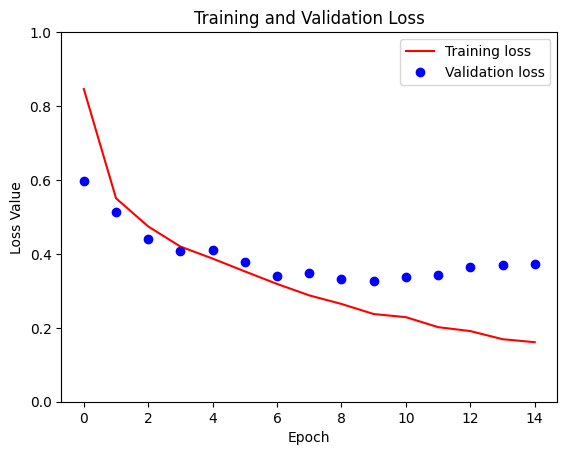

In [21]:
import matplotlib
loss = model_hist.history['loss']
val_loss = model_hist.history['val_loss']
from matplotlib import pyplot as plt
plt.figure()
plt.plot(model_hist.epoch, loss, 'r', label='Training loss')
plt.plot(model_hist.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()